This file is meant to test changes to the noisy gates library downloaded in this folder offline

get API key here: ```https://cloud.ibm.com/iam/apikeys```



In [1]:
# Standard libraries
import numpy as np
import json
import os, sys, importlib
from typing import List
from dotenv import load_dotenv
import matplotlib.pyplot as plt

# Qiskit
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.controlflow import ControlFlowOp
from qiskit.result import marginal_counts
from qiskit.transpiler import CouplingMap, Layout
from qiskit_ibm_runtime import QiskitRuntimeService

from qiskit_ibm_runtime.fake_provider import FakeBrisbane
  # try other Fake*V2 if needed
from quantum_gates.utilities import DeviceParameters

# 0) Point to the *parent* of the package folder
LOCAL_QG_PATH = r"..\src"   # or r"C:\Users\npace\Desktop\quantum-gates\src"
LOCAL_QG_PATH = os.path.abspath(LOCAL_QG_PATH)

# 1) Put local src at the very front of sys.path
if LOCAL_QG_PATH in sys.path:
    sys.path.remove(LOCAL_QG_PATH)
sys.path.insert(0, LOCAL_QG_PATH)

# 2) Purge any cached copies of the package
for m in list(sys.modules):
    if m == "quantum_gates" or m.startswith("quantum_gates."):
        del sys.modules[m]

# 3) Invalidate import caches and import the local package
importlib.invalidate_caches()
import quantum_gates

print("Using quantum_gates from:", quantum_gates.__file__)

# Own library
from quantum_gates.utilities import fix_counts
from quantum_gates.simulators import MrAndersonSimulator
from quantum_gates.gates import standard_gates
from quantum_gates.circuits import EfficientCircuit, BinaryCircuit
from quantum_gates.utilities import DeviceParameters
from quantum_gates.utilities import setup_backend
from quantum_gates.utilities import SurfaceCode
    

Using quantum_gates from: c:\Users\npace\Desktop\quantum-gates\src\quantum_gates\__init__.py


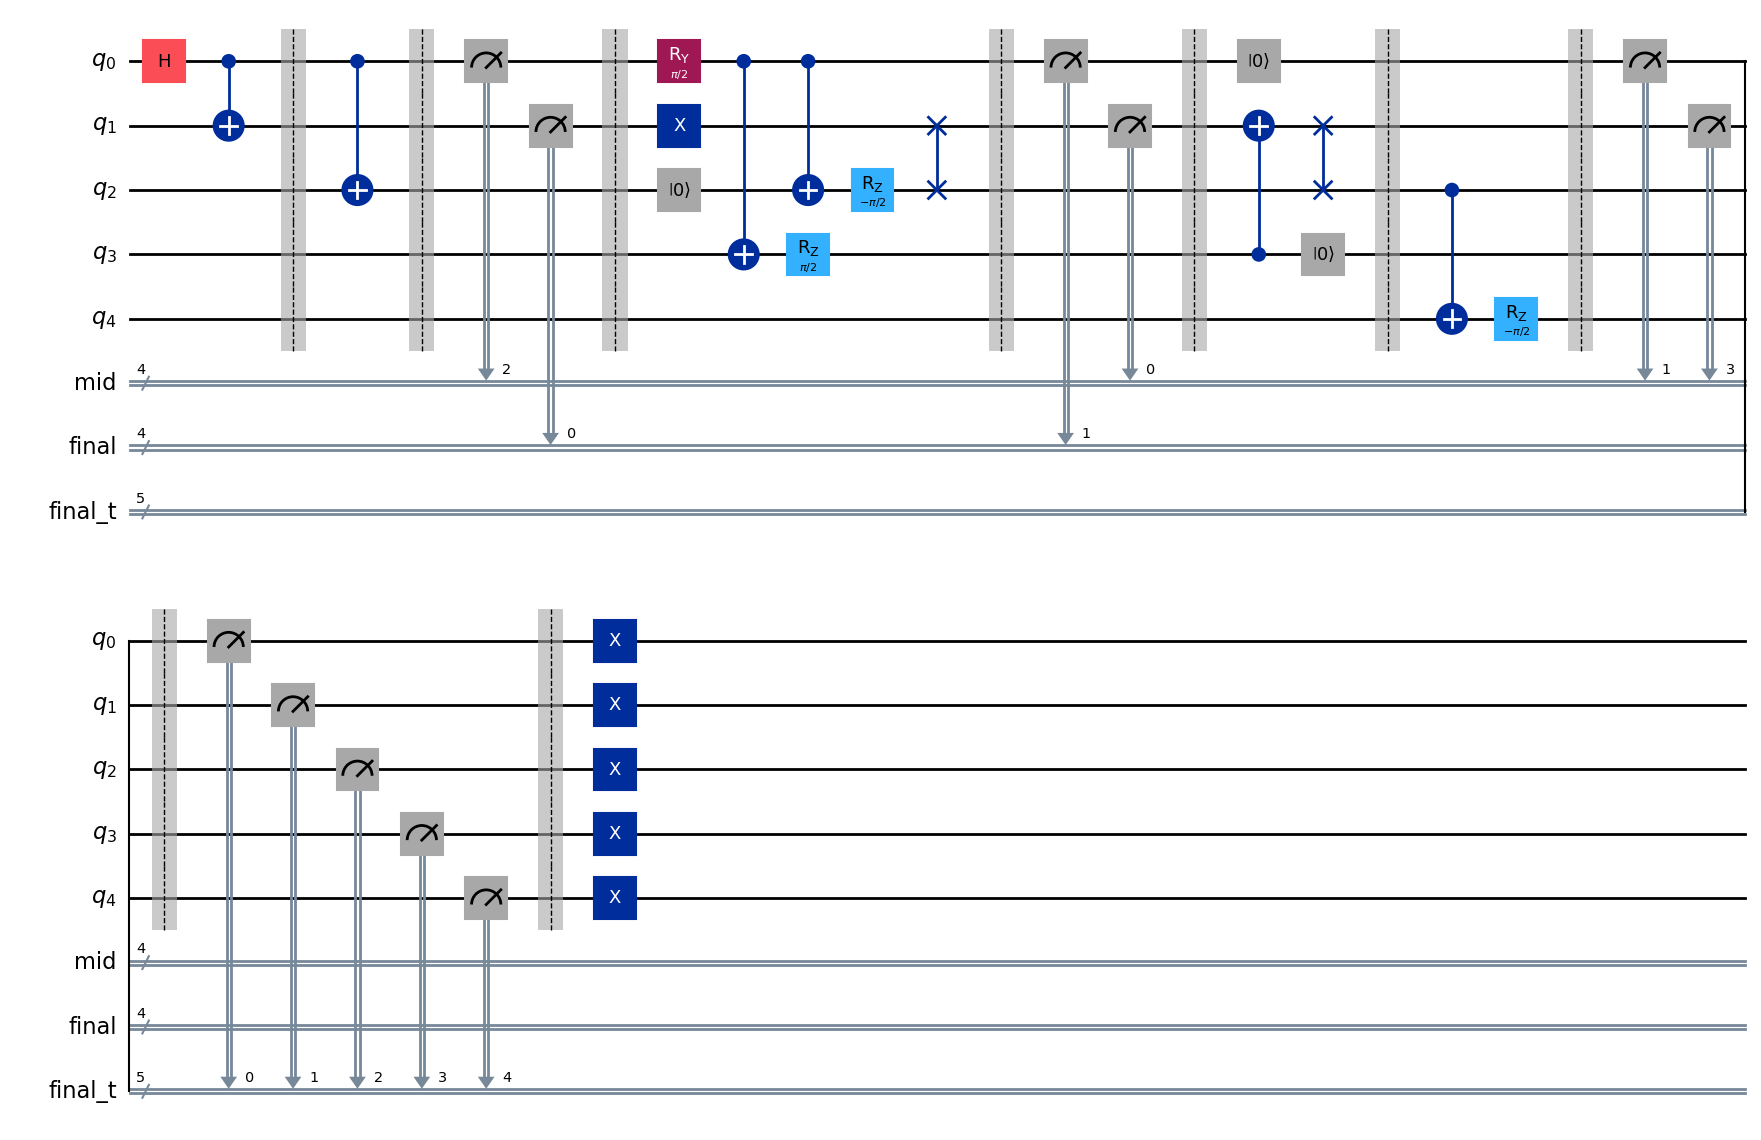

In [2]:

# Create explicit quantum and classical registers
N_q = 5 # Number of qubits in the code
N_m = 4 # Number of mid-measure classical bits

qreg = QuantumRegister(N_q, "q")
mid = ClassicalRegister(N_m, "mid")
final = ClassicalRegister(N_m, "final")
final_t = ClassicalRegister(N_q, "final_t")

# Build the circuit
qc = QuantumCircuit(qreg, mid, final, final_t)
# 1) Create a Bell state
qc.h(0)
qc.cx(0, 1)
qc.barrier()
qc.cx(0,2)
qc.barrier()
#qc.save_statevector(label="before_mid_measure")

# 2) Mid-circuit measure of qubit 0 into cbit 0
qc.measure(0, mid[2])
qc.measure(1, final[0])
qc.barrier()


# 3) Conditionally flip qubit 1 if the measurement was 1 (new control-flow API)
'''
with qc.if_test((qc.clbits[0], 1)):
    qc.x(1)
'''
qc.ry(np.pi/2, 0)
qc.cx(0,3)
qc.reset(2)
qc.x(1)
qc.rz(np.pi/2, 3)
qc.cx(0,2)
qc.rz(-np.pi/2, 2)
qc.swap(1,2)


qc.barrier()
qc.measure(qreg[0], final[1])
qc.measure(qreg[1], mid[0])

qc.barrier()
qc.cx(3, 1)
qc.reset(3)
qc.swap(2, 1)
#qc.x(5)
#qc.barrier()
qc.reset(0)
qc.barrier()
qc.cx(2, 4)
qc.rz(-np.pi/2, 4)
qc.barrier()

# 4) Final measurement
qc.measure(0, 1)
qc.measure(1, 3)

qc.barrier()

qc.measure(range(N_q), final_t)
qc.barrier()

qc.x(range(N_q))


qc.draw("mpl")


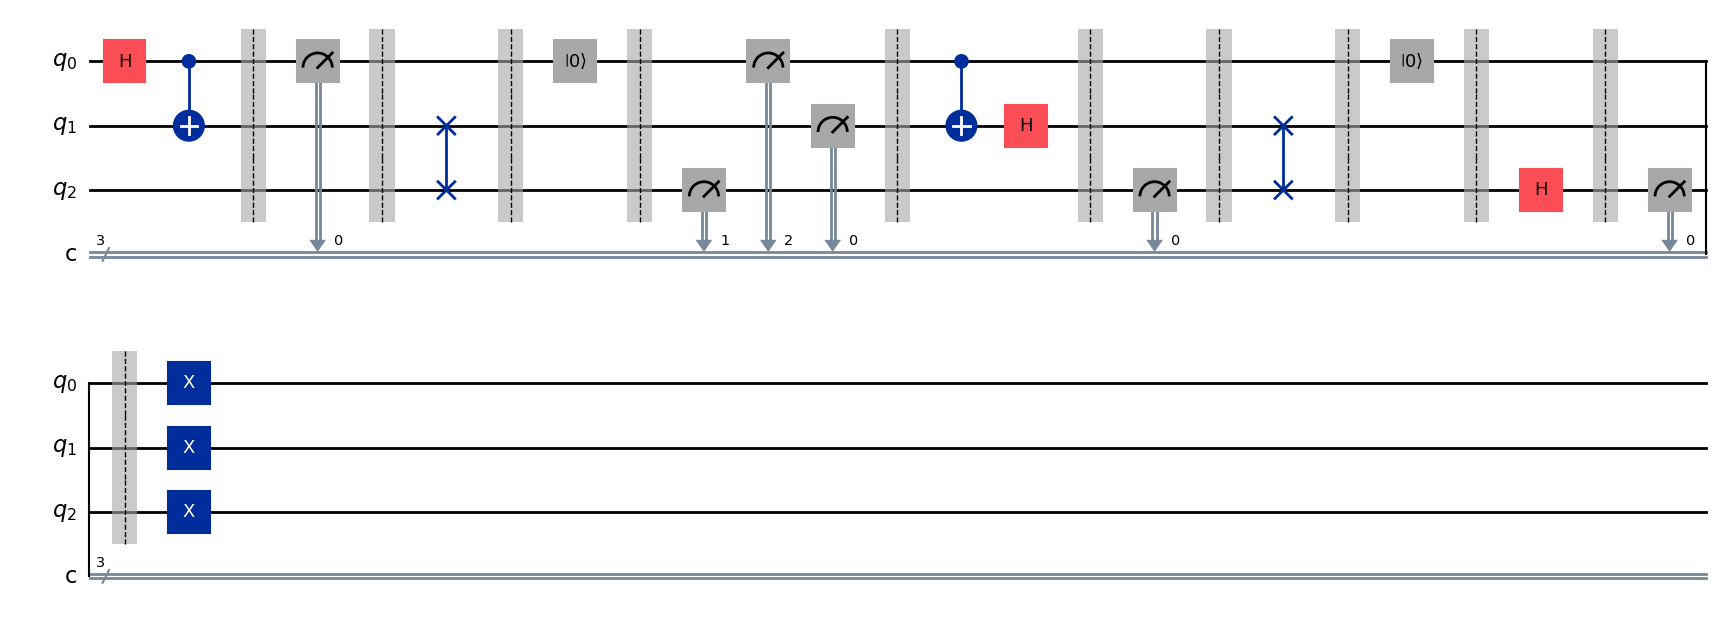

In [3]:
N_q = 3
qc_small = QuantumCircuit(3, 3)
qc_small.h(0)
qc_small.cx(0,1)
qc_small.barrier()
qc_small.measure(0,0)
qc_small.barrier()
qc_small.swap(1,2)
qc_small.barrier()  
qc_small.reset(0)
qc_small.barrier()
qc_small.measure(2,1)
qc_small.measure(0,2)
qc_small.measure(1,0)
qc_small.barrier()
qc_small.cx(0,1)
qc_small.h(1)
qc_small.barrier()
qc_small.measure(2,0)
qc_small.barrier()
qc_small.swap(1,2)
qc_small.barrier()

qc_small.reset(0)
qc_small.barrier()

qc_small.h(2)
qc_small.barrier()
qc_small.measure(2,0)

qc_small.barrier()



qc_small.x(range(3))
qc_small.draw("mpl")



In [4]:
# 1) Pick a fake backend
backend = FakeBrisbane()  # 127 qubits; change to another Fake*V2 if import fails

# 2) Use only N qubits
qubits_layout = list(range(N_q))

# 3) Load via YOUR class and save JSON next to the script
device_param = DeviceParameters(qubits_layout)
device_param.load_from_backend(backend)
device_param_lookup = device_param.__dict__()
device_param.save_to_json("./")  # writes ./device_parameters.json
print("Wrote ./device_parameters.json")

Device parameters are valid. We can save them. 
Device parameters saved successfully.
Wrote ./device_parameters.json


In [5]:

from quantum_gates.gates import NoiseFreeGates  # 

sim = MrAndersonSimulator(
    gates=NoiseFreeGates,        # <- ideal gates (no noise)
    CircuitClass=EfficientCircuit # or EfficientCircuit
)

bit_flip_bool = False
#cycles = 2
initial_psi = np.zeros(2**N_q)
initial_psi[0] = 1.0  # set |00...0⟩
initial_layout = list(range(N_q))  # logical qubit 0→physical 0, 1→1, etc.
shots = 100

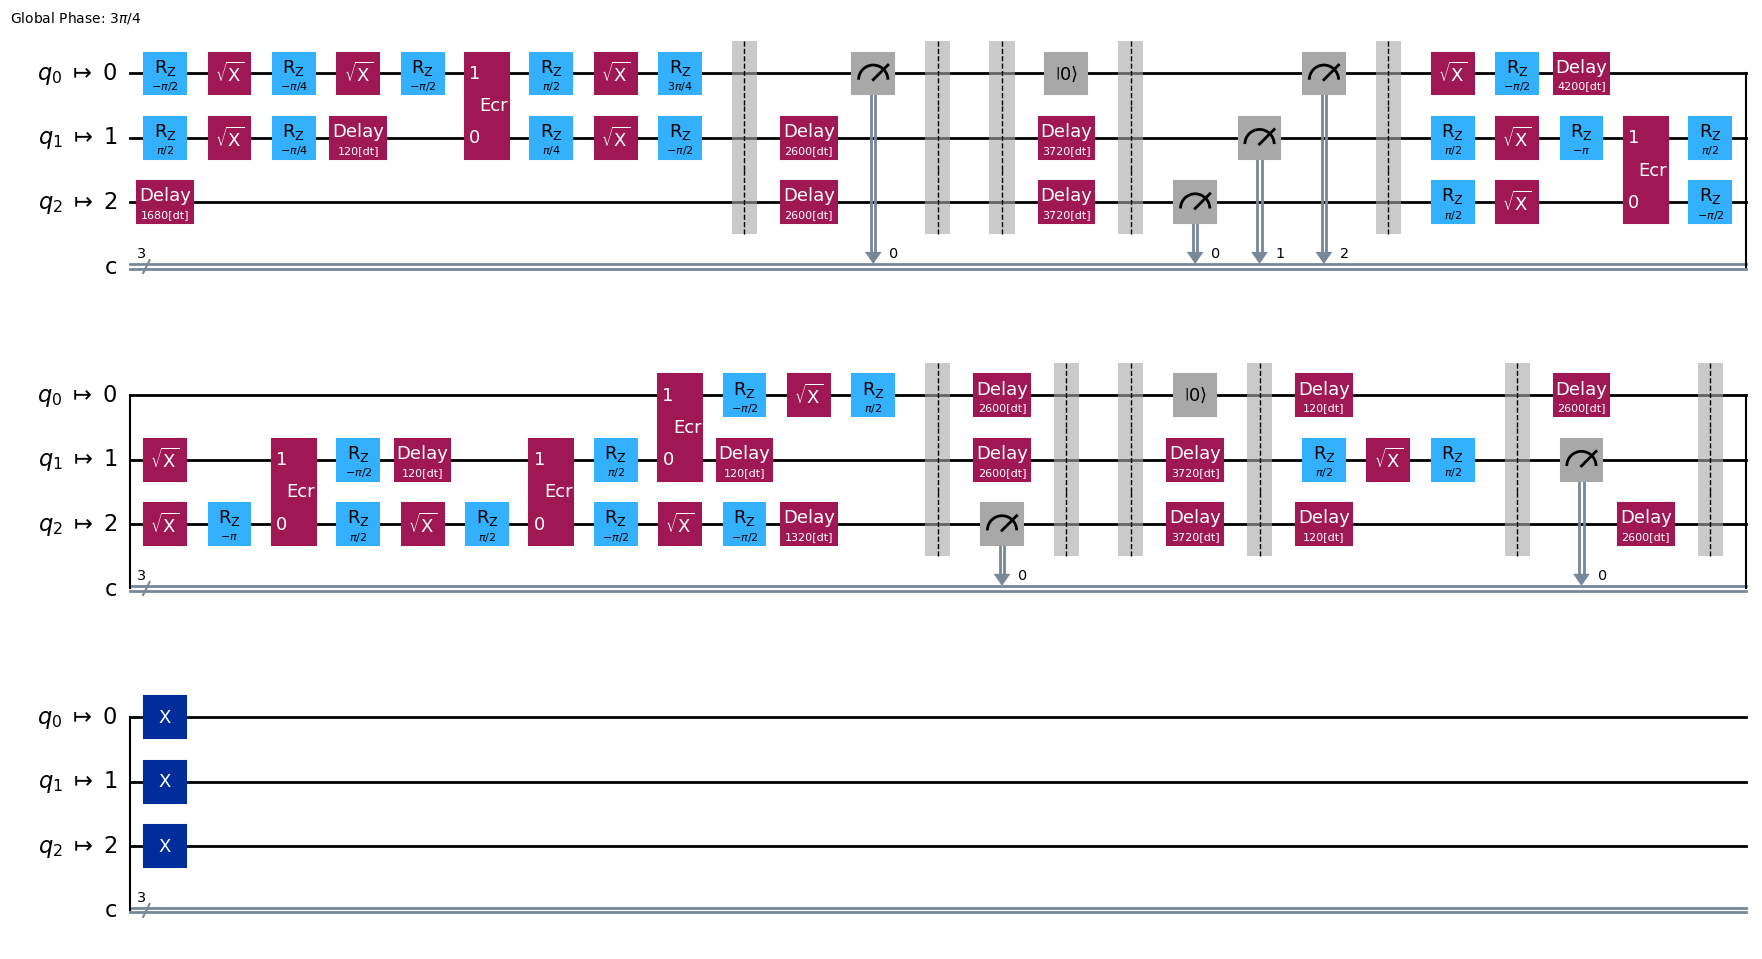

In [6]:



needs_controlflow = any(isinstance(op.operation, ControlFlowOp) for op in qc.data)

t_circ = transpile(
    qc_small,
    backend,
    initial_layout=qubits_layout,
    seed_transpiler=100,
    **({} if needs_controlflow else {"scheduling_method": "asap"})
)

t_circ.draw("mpl")

In [7]:

res  = sim.run( 
    t_qiskit_circ=t_circ, 
    qubits_layout=qubits_layout, 
    psi0=initial_psi, 
    shots=shots, 
    device_param=device_param_lookup,
    nqubit=N_q,
    bit_flip_bool=bit_flip_bool,
    )

probs = res["probs"]
results = res["results"]
num_clbits = res["num_clbits"]
mid_counts = res["mid_counts"]


print("Mid-circuit measurement results", results)
#print("Final measurement counts:", final_counts)
#print("Final measurement probabilities:", probs)
print("Number of classical bits in circuit:", num_clbits)
print("Mid-circuit measurement counts:", mid_counts)

---- Preprocessed data ----
Chunk 0: rz[0] , sx[0] , rz[0] , sx[0] , rz[0] , rz[1] , sx[1] , rz[1] , delay[1] , ecr[1, 0] , rz[0] , sx[0] , rz[0] , rz[1] , sx[1] , rz[1] , delay[2] , delay[1] , delay[2]
Fancy 1: mid_measurement qubits=[0] clbits=[0]
Fancy 2: reset_qubits qubits=[0]
Chunk 3: delay[1] , delay[2]
Fancy 4: mid_measurement qubits=[2] clbits=[0]
Fancy 5: mid_measurement qubits=[1] clbits=[1]
Fancy 6: mid_measurement qubits=[0] clbits=[2]
Chunk 7: sx[0] , rz[0] , delay[0] , rz[1] , sx[1] , rz[1] , rz[2] , sx[2] , ecr[2, 1] , rz[1] , sx[1] , rz[2] , sx[2] , rz[2] , ecr[2, 1] , rz[1] , delay[1] , rz[2] , sx[2] , rz[2] , ecr[2, 1] , rz[1] , ecr[1, 0] , rz[0] , sx[0] , rz[0] , delay[1] , rz[2] , sx[2] , rz[2] , delay[2] , delay[0] , delay[1]
Fancy 8: mid_measurement qubits=[2] clbits=[0]
Fancy 9: reset_qubits qubits=[0]
Chunk 10: delay[1] , delay[2] , delay[0] , rz[1] , sx[1] , rz[1] , delay[2] , delay[0]
Fancy 11: mid_measurement qubits=[1] clbits=[0]
Chunk 12: delay[2] , x[0] ,

Post processing and plotting hists

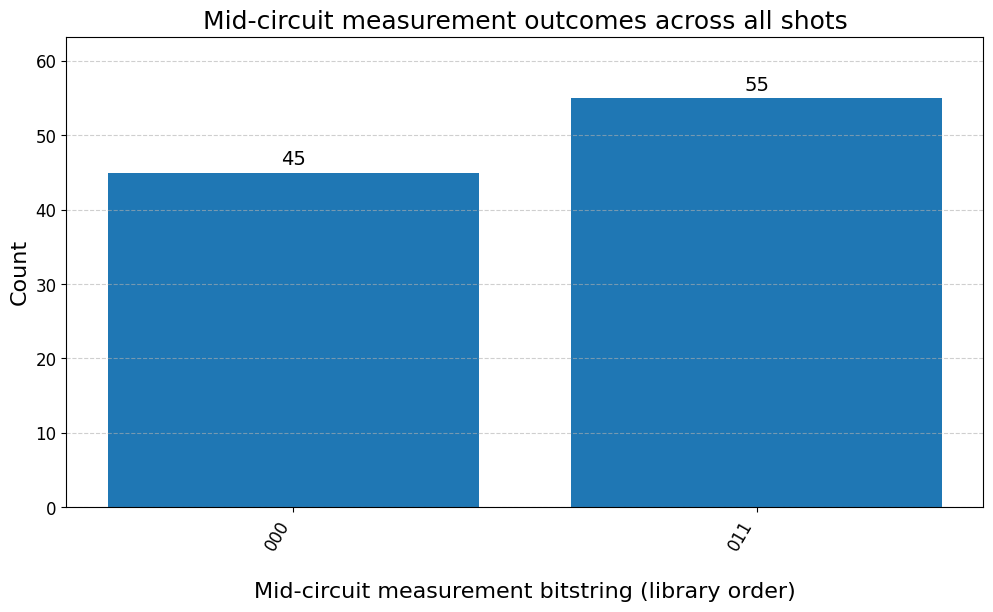

Mid-circuit measurement counts: {'000': 45, '011': 55}


In [8]:

# --- Plot histogram ---
labels = sorted(mid_counts.keys())
values = [mid_counts[k] for k in labels]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color="#1f77b4")  # same default Aer blue

# Extend y-axis a bit to fit annotations
max_val = max(values)
plt.ylim(0, max_val * 1.15)

# Annotate bar tops
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.5, str(val),
             ha='center', va='bottom', fontsize=14, color="black")

plt.xlabel("\nMid-circuit measurement bitstring (library order)", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.title("Mid-circuit measurement outcomes across all shots",fontsize=18)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.yticks(fontsize=12)
plt.xticks(rotation=60, ha="right", fontsize=12)   # tilt x-axis labels

plt.show()

# --- Optional printout ---
print("Mid-circuit measurement counts:", dict(mid_counts))

Modified Hist Plot of above 5% counts 

Filtered mid-circuit measurement counts

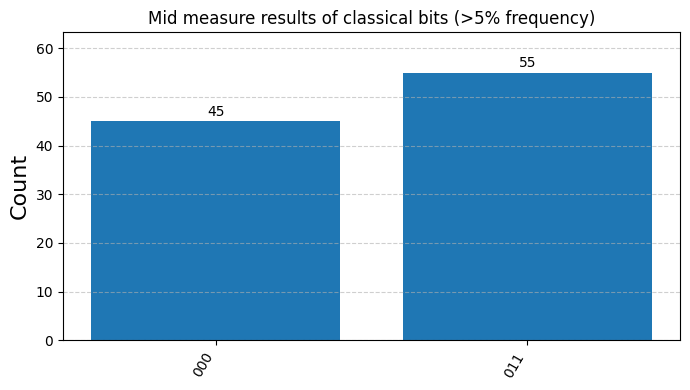

In [9]:
threshold = 0.05 * shots  # 5% cutoff

# --- Filter ---
filtered_counts = {k: v for k, v in mid_counts.items() if v >= threshold}

# --- Sort by bitstring (optional) ---
filtered_labels = list(sorted(filtered_counts.keys()))
filtered_values = [filtered_counts[k] for k in filtered_labels]

# --- Plot ---
plt.figure(figsize=(7, 4))
bars = plt.bar(filtered_labels, filtered_values, color="#1f77b4")  # same default Aer blue

# Extend y-axis a bit to fit annotations
max_val = max(filtered_values)
plt.ylim(0, max_val * 1.15)

# Annotate bar tops
for bar, val in zip(bars, filtered_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.5, str(val),
             ha='center', va='bottom', fontsize=10, color="black")

# Match Aer-style axes
plt.ylabel("Count", fontsize=16)
plt.xlabel("")  # Aer histograms usually skip x-axis label
plt.title("Mid measure results of classical bits (>5% frequency)", fontsize=12)
plt.xticks(rotation=60, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Tight layout to match Aer formatting
plt.tight_layout()
plt.show()

Probabilities Generated by Final Measures

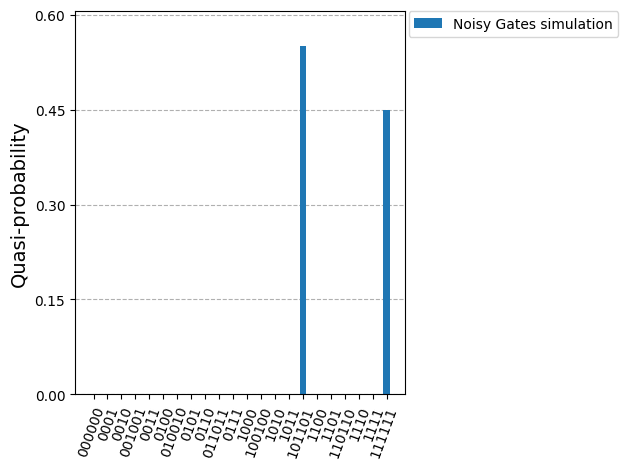

In [10]:
# Probabilities Generated by Final Measures
measured_qubit = N_m
counts_ng = fix_counts(probs, measured_qubit)
plot_histogram(counts_ng, bar_labels=False, legend=['Noisy Gates simulation'])

In [11]:
counts_ng

{'000000': 7.73189795705918e-66,
 '0001': 0,
 '0010': 0,
 '0011': 0,
 '0100': 0,
 '0101': 0,
 '0110': 0,
 '0111': 0,
 '1000': 0,
 '001001': 2.062169701160052e-33,
 '1010': 0,
 '1011': 0,
 '1100': 0,
 '1101': 0,
 '1110': 0,
 '1111': 0,
 '010010': 6.326098328502966e-66,
 '011011': 1.687229755494588e-33,
 '100100': 2.062169701160052e-33,
 '101101': 0.55,
 '110110': 1.687229755494588e-33,
 '111111': 0.45}

Comparison with AER

In [12]:
# Simulate with Aer
sim = AerSimulator()
#t_qc = transpile(qc, sim)
result = sim.run(t_circ, shots=shots).result()
counts = result.get_counts()

Aer All clbits counts: {'000': 41, '010': 59}


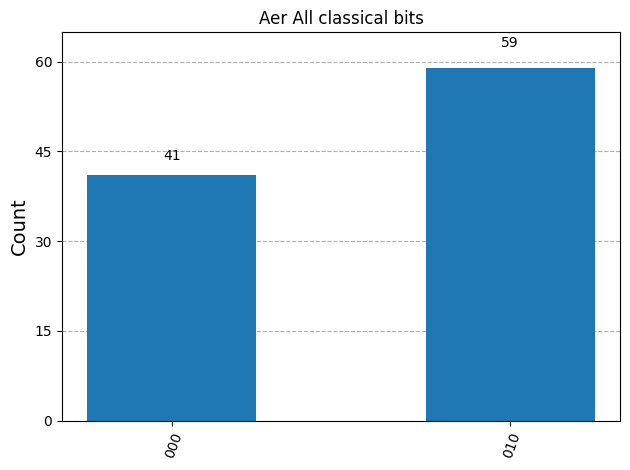

In [13]:
print("Aer All clbits counts:", counts)
plot_histogram(counts, title="Aer All classical bits")

Filtering Example

Truncated to final 2 bits: {'000': 41, '010': 59}


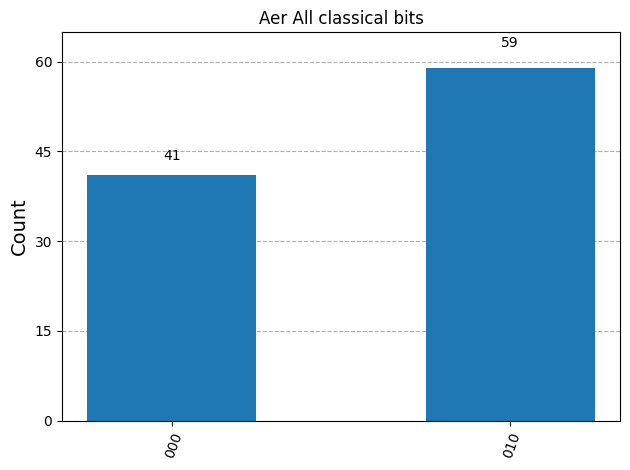

In [14]:
# Keep only the final measurement bits
final_counts = marginal_counts(counts, indices=range(N_q))

print("Truncated to final 2 bits:", final_counts)
plot_histogram(final_counts, title='Aer All classical bits')